In [1]:
import os
import json
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

import time
import gc
from dataclasses import dataclass
from typing import Dict, Any, List, Optional

import torch
from tqdm import tqdm
from vllm import LLM, SamplingParams
from pathlib import Path
from math_verify import parse, verify

repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

from will_replication.my_utils.utils import load_probe_data, sigmoid_np, load_labelled_probe_dataset, SIMPLE_MODEL_POOL_CONFIG, ModelConfig, verify_answer, add_majority_vote_answer, get_output_text
from thom_replication.utils.verification_math import compute_score, extract_solution, extract_gsm8k_solution

/opt/anaconda/envs/diff-direction/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-29 21:42:52 [__init__.py:241] Automatically detected platform cuda.


In [16]:
# PROBING CONGIG CSETUP
PROBE_RESULTS_DIR = "../../will_replication/probe_results/DATA"
LABELLED_SR_PATH = f"{PROBE_RESULTS_DIR}/Labelled_SR"
PROBE_DATA_PATH=f"{PROBE_RESULTS_DIR}/SR_DATA"
PROBING_DATASET = "MATH"

LABELLED_DATASET_FULL_NAME = "gneubig/aime-1983-2024"
LABELLED_DATASET_NAME = "_".join(LABELLED_DATASET_FULL_NAME.split("/"))

PROBE_MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
PROBE_MODEL_ALIAS = "-".join(PROBE_MODEL_NAME.split("/"))
K=1
TEMPERATURE=0.0


small_model_probe_data = load_probe_data(MODEL_NAME=PROBE_MODEL_NAME, PROBING_DATASET=PROBING_DATASET, K=K, TEMPERATURE=TEMPERATURE, DATA_PATH=PROBE_DATA_PATH)

labelled_datast_df = load_labelled_probe_dataset(MODEL_NAME=PROBE_MODEL_NAME, PROBE_SOURCE_DATASET=PROBING_DATASET, LABELLED_DATASET=LABELLED_DATASET_NAME, K=K, TEMPERATURE=TEMPERATURE, DATA_PATH=LABELLED_SR_PATH)

In [3]:
routing_dataset_df = labelled_datast_df.copy().sample(n=100, random_state=42)

# Route questions to a model

In [13]:
MODEL_POOL = list(SIMPLE_MODEL_POOL_CONFIG.keys())
MODEL_POOL

['Qwen/Qwen2.5-Math-1.5B-Instruct',
 'Qwen/Qwen2.5-Math-7B-Instruct',
 'Qwen/Qwen2.5-Math-72B-Instruct']

In [5]:
routing_dataset_df["route_to"] = PROBE_MODEL_NAME

In [6]:
routing_dataset_df.head(1)

,idx,dataset,prompt_scored,formatted,score_raw,score,layer,pos,original_solution,Year,Problem Number,route_to
830,830,gneubig/aime-1983-2024,Zou and Chou are practicing their $100$ -meter...,<|im_start|>system\nPlease reason step by step...,0.956127,0.722346,18,-1,97,2021,1,Qwen/Qwen2.5-Math-1.5B-Instruct


In [7]:
def route_questions(predicted_score:int, model_pool:list[str]):
    if predicted_score  >= 0.8: #really easy go to model 1 (0.8 - 1.0)
        return model_pool[0]
    elif predicted_score >= 0.5: #medium go to model 2  (0.5 - 0.8)
        return model_pool[1]
    else:
        return model_pool[2] #realy hard go to model 3 (0 - 0.49)

In [8]:
routing_dataset_df["route_to"] = routing_dataset_df["score"].apply(lambda x: route_questions(x, MODEL_POOL))

In [9]:
routing_dataset_df["route_to"].value_counts()

route_to
Qwen/Qwen2.5-Math-72B-Instruct     66
Qwen/Qwen2.5-Math-7B-Instruct      25
Qwen/Qwen2.5-Math-1.5B-Instruct     9
Name: count, dtype: int64

In [10]:
# Create a dictionary of DataFrames, each subset grouped by 'route_to'
route_to_subsets = {route: group for route, group in routing_dataset_df.groupby('route_to')}

In [11]:
list(route_to_subsets.keys())

['Qwen/Qwen2.5-Math-1.5B-Instruct',
 'Qwen/Qwen2.5-Math-72B-Instruct',
 'Qwen/Qwen2.5-Math-7B-Instruct']

In [12]:
len(route_to_subsets[list(route_to_subsets.keys())[0]]), len(route_to_subsets[list(route_to_subsets.keys())[1]]), len(route_to_subsets[list(route_to_subsets.keys())[2]])

(9, 66, 25)

# Answer each question with the model

In [13]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [14]:
@dataclass
class VLLMModelRunCfg:
    tensor_parallel_size: int = 1
    gpu_memory_utilization: float = 0.90
    max_model_len: int = 4096

In [15]:
params = SamplingParams(temperature=TEMPERATURE, n=1)

In [16]:
def unload_model(llm: LLM) -> None:
    try:
        if hasattr(llm, "llm_engine"):
            del llm.llm_engine
    except Exception:
        pass
    del llm
    gc.collect()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

In [17]:
print(routing_dataset_df["prompt_scored"].iloc[0])

Zou and Chou are practicing their $100$ -meter sprints by running $6$ races against each other. Zou wins the first race, and after that, the probability that one of them wins a race is $\frac23$ if they won the previous race but only $\frac13$ if they lost the previous race. The probability that Zou will win exactly $5$ of the $6$ races is $\frac mn$ , where $m$ and $n$ are relatively prime positive integers. Find $m+n$ . Let's think step by step and output the final answer within \boxed{}.


In [18]:
def batch_apply_chat_template(problems, tokenizer):
    prompt_store = []
    for problem in problems:
        messages = [
            {"role": "user", "content": problem}
        ]
        prompts = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        prompt_store.append(prompts)
    return prompt_store

def count_input_tokens_batch(prompts: list[str], tokenizer) -> list[int]:
    enc = tokenizer(prompts, add_special_tokens=False)
    # HF returns dict with "input_ids": List[List[int]]
    return [len(ids) for ids in enc["input_ids"]]

TOKENS_PER_MILLION = 1_000_000

In [19]:
def run_routed_vllm_inference(
    df: pd.DataFrame,
    *,
    route_col: str,
    prompt_col: str,
    out_text_col: str = "response_text",
    out_model_col: str = "response_model",
    input_num_tokens_col: str = "input_num_tokens",
    out_tok_col: str = "response_num_tokens",
    out_latency_col: str = "response_latency_s",
    out_err_col: str = "response_error",
    input_cost_col: str = "input_cost_usd",
    output_cost_col: str = "output_cost_usd",
    total_cost_col: str = "total_cost_usd",
    pricing_config: Optional[dict] = None,
    temperature: float = 0.0,
    max_tokens: int = 3000,
    n: int = 1,
    batch_size: int = 32,
    checkpoint_path: Optional[str] = None,
    model_run_cfgs: Optional[Dict[str, VLLMModelRunCfg]] = None,
) -> pd.DataFrame:
    """
    Runs vLLM inference grouped by df[route_col], and writes results back into df.
    Safe to resume if out_text_col already filled.
    """

    if model_run_cfgs is None:
        model_run_cfgs = {}

    if pricing_config is None:
        # pass SIMPLE_MODEL_POOL_CONFIG here when you call the function
        pricing_config = {}

    # Ensure output columns exist
    for col, default in [
        (out_text_col, None),
        (out_model_col, None),
        (input_num_tokens_col, np.nan),
        (out_tok_col, np.nan),
        (out_latency_col, np.nan),
        (out_err_col, None),
        (input_cost_col, np.nan),
        (output_cost_col, np.nan),
        (total_cost_col, np.nan),
    ]:
        if col not in df.columns:
            df[col] = default

    # Only process rows without outputs yet
    pending_mask = df[out_text_col].isna()
    if pending_mask.sum() == 0:
        print("✅ Nothing to do: all rows already have responses.")
        return df

    routes = df.loc[pending_mask, route_col].dropna().unique().tolist()
    print(f"Routes to run: {routes}")

    for model_name in routes:
        model_mask = pending_mask & (df[route_col] == model_name)
        idxs = df.index[model_mask].tolist()
        if not idxs:
            continue

        cfg = model_run_cfgs.get(model_name, VLLMModelRunCfg())
        print(f"\n=== Running model: {model_name} | rows: {len(idxs)} ===")
        print(f"vLLM cfg: {cfg}")

        # Pull pricing for this model (if available)
        model_costs = pricing_config.get(model_name, {}).get("model_costs", {})
        in_rate = model_costs.get("input_per_mill", None)   # USD per 1,000,000 input tokens
        out_rate = model_costs.get("output_per_mill", None) # USD per 1,000,000 output tokens
        has_pricing = (in_rate is not None) and (out_rate is not None)
        if not has_pricing:
            print(f"⚠️ No pricing found for {model_name} in pricing_config[...]['model_costs']; costs will be NaN.")

        if "72" in model_name:
            llm = LLM(
                model=model_name,
                tensor_parallel_size=cfg.tensor_parallel_size,
                gpu_memory_utilization=cfg.gpu_memory_utilization,
                max_model_len=cfg.max_model_len,
                max_num_seqs=64,
                max_num_batched_tokens=8192,
                # enforce_eager=True
            )
        else:
            llm = LLM(
                model=model_name,
                tensor_parallel_size=cfg.tensor_parallel_size,
                gpu_memory_utilization=cfg.gpu_memory_utilization,
                max_model_len=cfg.max_model_len,
            )

        sampling = SamplingParams(
            temperature=temperature,
            max_tokens=max_tokens,
            n=n,
        )

        tokenizer = llm.llm_engine.tokenizer.tokenizer


        # Process in batches
        for start in tqdm(range(0, len(idxs), batch_size), desc=f"Inferencing {model_name}"):
            batch_idxs = idxs[start : start + batch_size]
            problems = df.loc[batch_idxs, prompt_col].tolist()

            prompts = batch_apply_chat_template(problems, tokenizer)
            input_tok_counts = count_input_tokens_batch(prompts, tokenizer)


            t0 = time.time()
            try:
                outputs = llm.generate(prompts, sampling_params=sampling)
                latency = time.time() - t0

                # vLLM returns outputs aligned with prompts
                texts = []
                out_tok_counts = []
                errs = [None] * len(outputs)

                for out in outputs:
                    # If n>1 you might want list; here we take first completion by default
                    comp = out.outputs[0]
                    texts.append(comp.text)
                    out_tok_counts.append(len(comp.token_ids) if comp.token_ids is not None else np.nan)

                df.loc[batch_idxs, out_text_col] = texts
                df.loc[batch_idxs, out_model_col] = model_name
                df.loc[batch_idxs, input_num_tokens_col] = input_tok_counts
                df.loc[batch_idxs, out_tok_col] = out_tok_counts
                df.loc[batch_idxs, out_latency_col] = latency
                df.loc[batch_idxs, out_err_col] = errs

                # Compute + write costs (vectorized on the batch)
                if has_pricing:
                    in_arr = np.array(input_tok_counts, dtype=float)
                    out_arr = np.array(out_tok_counts, dtype=float)

                    input_costs = (in_arr / TOKENS_PER_MILLION) * float(in_rate)
                    output_costs = (out_arr / TOKENS_PER_MILLION) * float(out_rate)
                    total_costs = input_costs + output_costs

                    df.loc[batch_idxs, input_cost_col] = input_costs
                    df.loc[batch_idxs, output_cost_col] = output_costs
                    df.loc[batch_idxs, total_cost_col] = total_costs
                else:
                    df.loc[batch_idxs, input_cost_col] = np.nan
                    df.loc[batch_idxs, output_cost_col] = np.nan
                    df.loc[batch_idxs, total_cost_col] = np.nan

            except Exception as e:
                latency = time.time() - t0
                # record error per-row so you can retry later
                df.loc[batch_idxs, out_text_col] = None
                df.loc[batch_idxs, out_model_col] = model_name
                df.loc[batch_idxs, input_num_tokens_col] = np.nan
                df.loc[batch_idxs, out_tok_col] = np.nan
                df.loc[batch_idxs, out_latency_col] = latency
                df.loc[batch_idxs, out_err_col] = repr(e)

                # also blank costs on error
                df.loc[batch_idxs, input_cost_col] = np.nan
                df.loc[batch_idxs, output_cost_col] = np.nan
                df.loc[batch_idxs, total_cost_col] = np.nan
                
            # checkpoint frequently (optional)
            if checkpoint_path is not None:
                df.to_parquet(checkpoint_path, index=True)

        unload_model(llm)

        # refresh pending_mask for the next model
        pending_mask = df[out_text_col].isna()

        if checkpoint_path is not None:
            df.to_parquet(checkpoint_path, index=True)

    return df

In [20]:
model_run_cfgs = {
    "Qwen/Qwen2.5-Math-1.5B-Instruct": VLLMModelRunCfg(tensor_parallel_size=1, gpu_memory_utilization=0.60, max_model_len=4096),
    "Qwen/Qwen2.5-Math-7B-Instruct":   VLLMModelRunCfg(tensor_parallel_size=1, gpu_memory_utilization=0.70, max_model_len=4096),
    "Qwen/Qwen2.5-Math-72B-Instruct":  VLLMModelRunCfg(tensor_parallel_size=2, gpu_memory_utilization=0.92, max_model_len=4096),
}

In [21]:
routing_dataset_df.head()

,idx,dataset,prompt_scored,formatted,score_raw,score,layer,pos,original_solution,Year,Problem Number,route_to
830,830,gneubig/aime-1983-2024,Zou and Chou are practicing their $100$ -meter...,<|im_start|>system\nPlease reason step by step...,0.956127,0.722346,18,-1,97,2021,1,Qwen/Qwen2.5-Math-7B-Instruct
70,70,gneubig/aime-1983-2024,Compute \[\frac{(10^4+324)(22^4+324)(34^4+324)...,<|im_start|>system\nPlease reason step by step...,-0.575689,0.359925,18,-1,373,1987,14,Qwen/Qwen2.5-Math-72B-Instruct
631,631,gneubig/aime-1983-2024,"Let $A=\{1,2,3,4\}$ , and $f$ and $g$ be rando...",<|im_start|>system\nPlease reason step by step...,0.533384,0.630272,18,-1,453,2014,12,Qwen/Qwen2.5-Math-7B-Instruct
506,506,gneubig/aime-1983-2024,The sequence $(a_n)$ satisfies $a_0=0$ and $a_...,<|im_start|>system\nPlease reason step by step...,-0.070733,0.482324,18,-1,983,2009,14,Qwen/Qwen2.5-Math-72B-Instruct
704,704,gneubig/aime-1983-2024,Triangle $ABC$ is inscribed in circle $\omega$...,<|im_start|>system\nPlease reason step by step...,-1.206015,0.230407,18,-1,43,2016,10,Qwen/Qwen2.5-Math-72B-Instruct


In [22]:
# 3) Run inference and write results back into the SAME df
routing_dataset_df = run_routed_vllm_inference(
    routing_dataset_df,
    route_col="route_to",
    prompt_col="prompt_scored",
    out_text_col="routed_response_text",
    input_num_tokens_col='input_num_tokens',
    temperature=TEMPERATURE,
    max_tokens=3000,
    batch_size=16,  # raise if stable, lower if OOM
    checkpoint_path="aime_routed_outputs.parquet",
    pricing_config=SIMPLE_MODEL_POOL_CONFIG,
    model_run_cfgs=model_run_cfgs,
)

Routes to run: ['Qwen/Qwen2.5-Math-7B-Instruct', 'Qwen/Qwen2.5-Math-72B-Instruct', 'Qwen/Qwen2.5-Math-1.5B-Instruct']

=== Running model: Qwen/Qwen2.5-Math-7B-Instruct | rows: 25 ===
vLLM cfg: VLLMModelRunCfg(tensor_parallel_size=1, gpu_memory_utilization=0.7, max_model_len=4096)
INFO 12-26 19:51:49 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-7B-Instruct', 'max_model_len': 4096, 'gpu_memory_utilization': 0.7, 'disable_log_stats': True}


INFO 12-26 19:51:58 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 12-26 19:51:59 [__init__.py:1750] Using max model len 4096


2025-12-26 19:52:00,356	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


INFO 12-26 19:52:00 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=16384.
(EngineCore_0 pid=3059686) INFO 12-26 19:52:01 [core.py:636] Waiting for init message from front-end.
(EngineCore_0 pid=3059686) INFO 12-26 19:52:01 [core.py:74] Initializing a V1 LLM engine (v0.10.1.1) with config: model='Qwen/Qwen2.5-Math-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-Math-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=Observability

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:01,  2.05it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.01it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.95it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.91it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.94it/s]
(EngineCore_0 pid=3059686) 


(EngineCore_0 pid=3059686) INFO 12-26 19:52:09 [default_loader.py:262] Loading weights took 2.12 seconds
(EngineCore_0 pid=3059686) INFO 12-26 19:52:10 [gpu_model_runner.py:2007] Model loading took 14.2419 GiB and 2.782169 seconds
(EngineCore_0 pid=3059686) INFO 12-26 19:52:15 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/4858120f0f/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_0 pid=3059686) INFO 12-26 19:52:15 [backends.py:559] Dynamo bytecode transform time: 5.47 s
(EngineCore_0 pid=3059686) INFO 12-26 19:52:19 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.199 s
(EngineCore_0 pid=3059686) INFO 12-26 19:52:19 [monitor.py:34] torch.compile takes 5.47 s in total
(EngineCore_0 pid=3059686) INFO 12-26 19:52:20 [gpu_worker.py:276] Available KV cache memory: 35.47 GiB
(EngineCore_0 pid=3059686) INFO 12-26 19:52:21 [kv_cache_utils.py:849] GPU KV cache size: 664,144 tokens
(EngineCore_0 pid=30

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 37.91it/s]


(EngineCore_0 pid=3059686) INFO 12-26 19:52:23 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.64 GiB
(EngineCore_0 pid=3059686) INFO 12-26 19:52:23 [core.py:214] init engine (profile, create kv cache, warmup model) took 12.93 seconds
INFO 12-26 19:52:23 [llm.py:298] Supported_tasks: ['generate']


Inferencing Qwen/Qwen2.5-Math-7B-Instruct: 100%|██████████| 2/2 [00:40<00:00, 20.45s/it]



=== Running model: Qwen/Qwen2.5-Math-72B-Instruct | rows: 66 ===
vLLM cfg: VLLMModelRunCfg(tensor_parallel_size=2, gpu_memory_utilization=0.92, max_model_len=4096)
INFO 12-26 19:53:08 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-72B-Instruct', 'max_model_len': 4096, 'tensor_parallel_size': 2, 'gpu_memory_utilization': 0.92, 'max_num_batched_tokens': 8192, 'max_num_seqs': 64, 'disable_log_stats': True}
INFO 12-26 19:53:09 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM
INFO 12-26 19:53:09 [__init__.py:1750] Using max model len 4096
INFO 12-26 19:53:10 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 12-26 19:53:11 [__init__.py:2921] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 12-26 19:53:17 [__init__.py:241] Automatically

Loading safetensors checkpoint shards:   0% Completed | 0/37 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:   3% Completed | 1/37 [00:00<00:22,  1.63it/s]
Loading safetensors checkpoint shards:   5% Completed | 2/37 [00:01<00:20,  1.68it/s]
Loading safetensors checkpoint shards:   8% Completed | 3/37 [00:01<00:19,  1.74it/s]
Loading safetensors checkpoint shards:  11% Completed | 4/37 [00:02<00:20,  1.61it/s]
Loading safetensors checkpoint shards:  14% Completed | 5/37 [00:03<00:20,  1.54it/s]
Loading safetensors checkpoint shards:  16% Completed | 6/37 [00:03<00:19,  1.56it/s]
Loading safetensors checkpoint shards:  19% Completed | 7/37 [00:04<00:18,  1.66it/s]
Loading safetensors checkpoint shards:  22% Completed | 8/37 [00:04<00:16,  1.72it/s]
Loading safetensors checkpoint shards:  24% Completed | 9/37 [00:05<00:16,  1.66it/s]
Loading safetensors checkpoint shards:  27% Completed | 10/37 [00:05<00:14,  1.83it/s]
Loading safetensors checkpoint shards:  30% Completed | 11/37

(VllmWorker TP1 pid=3062570) INFO 12-26 19:53:53 [default_loader.py:262] Loading weights took 21.39 seconds


Loading safetensors checkpoint shards:  97% Completed | 36/37 [00:21<00:00,  1.64it/s]


(VllmWorker TP1 pid=3062570) INFO 12-26 19:53:54 [gpu_model_runner.py:2007] Model loading took 67.7935 GiB and 22.137338 seconds


Loading safetensors checkpoint shards: 100% Completed | 37/37 [00:21<00:00,  1.66it/s]
Loading safetensors checkpoint shards: 100% Completed | 37/37 [00:21<00:00,  1.70it/s]
(VllmWorker TP0 pid=3062569) 


(VllmWorker TP0 pid=3062569) INFO 12-26 19:53:54 [default_loader.py:262] Loading weights took 21.76 seconds
(VllmWorker TP0 pid=3062569) INFO 12-26 19:53:54 [gpu_model_runner.py:2007] Model loading took 67.7935 GiB and 22.839806 seconds
(VllmWorker TP1 pid=3062570) INFO 12-26 19:54:06 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/9b2b1d4bcb/rank_1_0/backbone for vLLM's torch.compile
(VllmWorker TP1 pid=3062570) INFO 12-26 19:54:06 [backends.py:559] Dynamo bytecode transform time: 12.04 s
(VllmWorker TP0 pid=3062569) INFO 12-26 19:54:07 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/9b2b1d4bcb/rank_0_0/backbone for vLLM's torch.compile
(VllmWorker TP0 pid=3062569) INFO 12-26 19:54:07 [backends.py:559] Dynamo bytecode transform time: 12.78 s
(VllmWorker TP1 pid=3062570) INFO 12-26 19:54:16 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 9.150 s
(VllmWorker TP0 p

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 19/19 [00:01<00:00, 15.13it/s]


(VllmWorker TP1 pid=3062570) INFO 12-26 19:54:23 [custom_all_reduce.py:196] Registering 3059 cuda graph addresses
(VllmWorker TP0 pid=3062569) INFO 12-26 19:54:23 [custom_all_reduce.py:196] Registering 3059 cuda graph addresses
(VllmWorker TP1 pid=3062570) INFO 12-26 19:54:23 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.44 GiB
(VllmWorker TP0 pid=3062569) INFO 12-26 19:54:23 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.44 GiB
(EngineCore_0 pid=3062104) INFO 12-26 19:54:23 [core.py:214] init engine (profile, create kv cache, warmup model) took 28.76 seconds
INFO 12-26 19:54:24 [llm.py:298] Supported_tasks: ['generate']


Inferencing Qwen/Qwen2.5-Math-72B-Instruct: 100%|██████████| 5/5 [05:42<00:00, 68.47s/it]


(VllmWorker TP0 pid=3062569) INFO 12-26 20:00:06 [multiproc_executor.py:520] Parent process exited, terminating worker
(VllmWorker TP1 pid=3062570) INFO 12-26 20:00:06 [multiproc_executor.py:520] Parent process exited, terminating worker

=== Running model: Qwen/Qwen2.5-Math-1.5B-Instruct | rows: 9 ===
vLLM cfg: VLLMModelRunCfg(tensor_parallel_size=1, gpu_memory_utilization=0.6, max_model_len=4096)
INFO 12-26 20:00:10 [utils.py:326] non-default args: {'model': 'Qwen/Qwen2.5-Math-1.5B-Instruct', 'max_model_len': 4096, 'gpu_memory_utilization': 0.6, 'disable_log_stats': True}
INFO 12-26 20:00:11 [__init__.py:711] Resolved architecture: Qwen2ForCausalLM
INFO 12-26 20:00:11 [__init__.py:1750] Using max model len 4096
INFO 12-26 20:00:11 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 12-26 20:00:20 [__init__.py:241] Automatically detected platform cuda.
(EngineCore_0 pid=3075198) INFO 12-26 20:00:22 [core.py:636] Waiting for init message from front-end

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.07it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.07it/s]
(EngineCore_0 pid=3075198) 


(EngineCore_0 pid=3075198) INFO 12-26 20:00:26 [default_loader.py:262] Loading weights took 0.59 seconds
(EngineCore_0 pid=3075198) INFO 12-26 20:00:26 [gpu_model_runner.py:2007] Model loading took 2.8798 GiB and 1.293867 seconds
(EngineCore_0 pid=3075198) INFO 12-26 20:00:32 [backends.py:548] Using cache directory: /home/lina4335/.cache/vllm/torch_compile_cache/63465de3ab/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_0 pid=3075198) INFO 12-26 20:00:32 [backends.py:559] Dynamo bytecode transform time: 5.14 s
(EngineCore_0 pid=3075198) INFO 12-26 20:00:35 [backends.py:161] Directly load the compiled graph(s) for dynamic shape from the cache, took 3.149 s
(EngineCore_0 pid=3075198) INFO 12-26 20:00:36 [monitor.py:34] torch.compile takes 5.14 s in total
(EngineCore_0 pid=3075198) INFO 12-26 20:00:36 [gpu_worker.py:276] Available KV cache memory: 38.98 GiB
(EngineCore_0 pid=3075198) INFO 12-26 20:00:37 [kv_cache_utils.py:849] GPU KV cache size: 1,459,856 tokens
(EngineCore_0 pid=3

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:01<00:00, 48.52it/s]


(EngineCore_0 pid=3075198) INFO 12-26 20:00:38 [gpu_model_runner.py:2708] Graph capturing finished in 2 secs, took 0.58 GiB
(EngineCore_0 pid=3075198) INFO 12-26 20:00:38 [core.py:214] init engine (profile, create kv cache, warmup model) took 11.87 seconds
INFO 12-26 20:00:39 [llm.py:298] Supported_tasks: ['generate']


Inferencing Qwen/Qwen2.5-Math-1.5B-Instruct: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]
[rank0]:[W1226 20:00:43.604052336 ProcessGroupNCCL.cpp:1479] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


In [3]:
# LABELLED_DATASETS_LIST = ["opencompass/AIME2025","gneubig/aime-1983-2024", "DigitalLearningGmbH/MATH-lighteval", "openai/gsm8k"]
ROUTED_DS_NAME = "openai_gsm8k"
ROUTED_DS_NAME = "gneubig_aime-1983-2024"
ROUTED_DS_NAME = "opencompass_AIME2025"
ROUTED_DF = pd.read_parquet(f"{ROUTED_DS_NAME}_routed_final.parquet")
# ROUTED_DF = pd.read_parquet("gneubig_aime-1983-2024_routed_final.parquet")

In [4]:
ROUTED_DF

,idx,dataset,prompt_scored,formatted,score_raw,score,layer,pos,original_solution,route_to,prompt_text,routed_response_text,response_model,input_num_tokens,response_num_tokens,response_latency_s,response_error,input_cost_usd,output_cost_usd,total_cost_usd
0,0,opencompass/AIME2025,Find the sum of all integer bases $b>9$ for wh...,<|im_start|>system\nPlease reason step by step...,1.275801,0.781734,18,-1,70,Qwen/Qwen2.5-Math-7B-Instruct,<|im_start|>system\nPlease reason step by step...,To determine the sum of all integer bases \( b...,Qwen/Qwen2.5-Math-7B-Instruct,74.0,1455.0,9.576139,None,0.000011,0.000418,0.000428
1,1,opencompass/AIME2025,"On $\triangle ABC$ points $A,D,E$, and $B$ lie...",<|im_start|>system\nPlease reason step by step...,-1.922650,0.127566,18,-1,588,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,"To find the area of the heptagon \(AFNBCEM\), ...",Qwen/Qwen2.5-Math-72B-Instruct,184.0,1068.0,89.241601,None,0.000106,0.001838,0.001944
2,2,opencompass/AIME2025,The 9 members of a baseball team went to an ic...,<|im_start|>system\nPlease reason step by step...,-1.215936,0.228652,18,-1,16,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,To determine the number of different assignmen...,Qwen/Qwen2.5-Math-72B-Instruct,153.0,919.0,89.241601,None,0.000088,0.001582,0.001669
3,3,opencompass/AIME2025,"Find the number of ordered pairs $(x,y)$, wher...",<|im_start|>system\nPlease reason step by step...,-0.583579,0.358109,18,-1,117,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,"To find the number of ordered pairs \((x, y)\)...",Qwen/Qwen2.5-Math-72B-Instruct,98.0,950.0,89.241601,None,0.000056,0.001635,0.001691
4,4,opencompass/AIME2025,There are $8!=40320$ eight-digit positive inte...,<|im_start|>system\nPlease reason step by step...,-0.421450,0.396170,18,-1,279,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,To determine the number of eight-digit positiv...,Qwen/Qwen2.5-Math-72B-Instruct,116.0,1344.0,89.241601,None,0.000067,0.002313,0.002380
5,5,opencompass/AIME2025,An isosceles trapezoid has an inscribed circle...,<|im_start|>system\nPlease reason step by step...,-0.410023,0.398907,18,-1,504,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,Given an isosceles trapezoid with an inscribed...,Qwen/Qwen2.5-Math-72B-Instruct,127.0,975.0,89.241601,None,0.000073,0.001678,0.001751
6,6,opencompass/AIME2025,"The twelve letters $A,B,C,D,E,F,G,H,I,J,K$, an...",<|im_start|>system\nPlease reason step by step...,-1.401144,0.197635,18,-1,821,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,To determine the probability that the last wor...,Qwen/Qwen2.5-Math-72B-Instruct,162.0,371.0,89.241601,None,0.000093,0.000638,0.000731
7,7,opencompass/AIME2025,Let $k$ be real numbers such that the system $...,<|im_start|>system\nPlease reason step by step...,-1.006006,0.267762,18,-1,77,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,"To solve the given system of equations, we sta...",Qwen/Qwen2.5-Math-72B-Instruct,139.0,3000.0,89.241601,None,0.000080,0.005163,0.005243
8,8,opencompass/AIME2025,The parabola with equation $y=x^{2}-4$ is rota...,<|im_start|>system\nPlease reason step by step...,-1.353177,0.205351,18,-1,62,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,To find the point of intersection of the origi...,Qwen/Qwen2.5-Math-72B-Instruct,143.0,1647.0,89.241601,None,0.000082,0.002834,0.002917
9,9,opencompass/AIME2025,The 27 cells of a $3\times9$ grid are filled i...,<|im_start|>system\nPlease reason step by step...,-3.451711,0.030718,18,-1,81,Qwen/Qwen2.5-Math-72B-Instruct,<|im_start|>system\nPlease reason step by step...,To determine the number of different ways to f...,Qwen/Qwen2.5-Math-72B-Instruct,283.0,852.0,89.241601,None,0.000162,0.001466,0.001629


In [55]:
def try_extract_solution(sol):
    try:
        return extract_solution(sol)
    except:
        return ""

In [6]:
ROUTED_DF["routed_extracted_ans"] = ROUTED_DF["routed_response_text"].apply(lambda x: try_extract_solution(x))

if "gsm8k" in ROUTED_DS_NAME.lower():
    ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"].apply(extract_gsm8k_solution)
elif "aime" in ROUTED_DS_NAME.lower():
    ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"]
else:
    ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"].apply(extract_solution)

RESP_LIST = ROUTED_DF["routed_response_text"].tolist()
GT_LIST = ROUTED_DF["extracted_gts"].tolist()
ROUTED_IS_CORRECT_LIST = []

for idx, res in enumerate(RESP_LIST):
    score = compute_score(solution_str=res, ground_truth=GT_LIST[idx])
#     gold = parse(f"${GT_LIST[idx]}$")
#     answer = parse(f"${res}$")
#     score = verify(gold=gold, target=answer)
    ROUTED_IS_CORRECT_LIST.append(score)
    
ROUTED_DF["routed_is_correct"] = ROUTED_IS_CORRECT_LIST
# ROUTED_DF["routed_is_correct"] = ROUTED_DF.apply(lambda row: compute_score(solution_str=row["routed_response_text"], ground_truth=ROUTED_DF["extracted_gts"]), axis=1)

In [7]:
ROUTED_DF

,idx,dataset,prompt_scored,formatted,score_raw,score,layer,pos,original_solution,route_to,...,input_num_tokens,response_num_tokens,response_latency_s,response_error,input_cost_usd,output_cost_usd,total_cost_usd,routed_extracted_ans,extracted_gts,routed_is_correct
0,0,opencompass/AIME2025,Find the sum of all integer bases $b>9$ for wh...,<|im_start|>system\nPlease reason step by step...,1.275801,0.781734,18,-1,70,Qwen/Qwen2.5-Math-7B-Instruct,...,74.0,1455.0,9.576139,None,0.000011,0.000418,0.000428,70,70,1.0
1,1,opencompass/AIME2025,"On $\triangle ABC$ points $A,D,E$, and $B$ lie...",<|im_start|>system\nPlease reason step by step...,-1.922650,0.127566,18,-1,588,Qwen/Qwen2.5-Math-72B-Instruct,...,184.0,1068.0,89.241601,None,0.000106,0.001838,0.001944,504,588,0.0
2,2,opencompass/AIME2025,The 9 members of a baseball team went to an ic...,<|im_start|>system\nPlease reason step by step...,-1.215936,0.228652,18,-1,16,Qwen/Qwen2.5-Math-72B-Instruct,...,153.0,919.0,89.241601,None,0.000088,0.001582,0.001669,364,16,0.0
3,3,opencompass/AIME2025,"Find the number of ordered pairs $(x,y)$, wher...",<|im_start|>system\nPlease reason step by step...,-0.583579,0.358109,18,-1,117,Qwen/Qwen2.5-Math-72B-Instruct,...,98.0,950.0,89.241601,None,0.000056,0.001635,0.001691,134,117,0.0
4,4,opencompass/AIME2025,There are $8!=40320$ eight-digit positive inte...,<|im_start|>system\nPlease reason step by step...,-0.421450,0.396170,18,-1,279,Qwen/Qwen2.5-Math-72B-Instruct,...,116.0,1344.0,89.241601,None,0.000067,0.002313,0.002380,279,279,1.0
5,5,opencompass/AIME2025,An isosceles trapezoid has an inscribed circle...,<|im_start|>system\nPlease reason step by step...,-0.410023,0.398907,18,-1,504,Qwen/Qwen2.5-Math-72B-Instruct,...,127.0,975.0,89.241601,None,0.000073,0.001678,0.001751,504,504,1.0
6,6,opencompass/AIME2025,"The twelve letters $A,B,C,D,E,F,G,H,I,J,K$, an...",<|im_start|>system\nPlease reason step by step...,-1.401144,0.197635,18,-1,821,Qwen/Qwen2.5-Math-72B-Instruct,...,162.0,371.0,89.241601,None,0.000093,0.000638,0.000731,16,821,0.0
7,7,opencompass/AIME2025,Let $k$ be real numbers such that the system $...,<|im_start|>system\nPlease reason step by step...,-1.006006,0.267762,18,-1,77,Qwen/Qwen2.5-Math-72B-Instruct,...,139.0,3000.0,89.241601,None,0.000080,0.005163,0.005243,7,77,0.0
8,8,opencompass/AIME2025,The parabola with equation $y=x^{2}-4$ is rota...,<|im_start|>system\nPlease reason step by step...,-1.353177,0.205351,18,-1,62,Qwen/Qwen2.5-Math-72B-Instruct,...,143.0,1647.0,89.241601,None,0.000082,0.002834,0.002917,11,62,0.0
9,9,opencompass/AIME2025,The 27 cells of a $3\times9$ grid are filled i...,<|im_start|>system\nPlease reason step by step...,-3.451711,0.030718,18,-1,81,Qwen/Qwen2.5-Math-72B-Instruct,...,283.0,852.0,89.241601,None,0.000162,0.001466,0.001629,44,81,0.0


In [9]:
if "aime2025" in ROUTED_DS_NAME.lower():
    OG_BENCHMARK_PATH = f"../../will_replication/DATA/SR_DATA/{ROUTED_DS_NAME}/test-{MODEL_ALIAS}_maxlen_3000_k_1_temp_0.0.parquet"
elif "aime" in ROUTED_DS_NAME.lower():
    OG_BENCHMARK_PATH = f"../../will_replication/DATA/SR_DATA/{ROUTED_DS_NAME}/train-{MODEL_ALIAS}_maxlen_3000_k_1_temp_0.0.parquet"
else:
    OG_BENCHMARK_PATH = f"../../will_replication/DATA/SR_DATA/{ROUTED_DS_NAME}/test-{MODEL_ALIAS}_maxlen_3000_k_1_temp_0.0.parquet"

og_benchmark_df = pd.read_parquet(OG_BENCHMARK_PATH)

In [10]:
benchmark_score, benchmark_cost = og_benchmark_df["success_rate"].mean(), og_benchmark_df["total_cost_usd"].sum()
print(f"Routing breakdown for {MODEL_ALIAS}")
print(f"Original Pass@1 📖: {benchmark_score}")
print(f"Original Cost 💰: {benchmark_cost}\n")

routed_benchmark_score, routed_benchmark_cost = ROUTED_DF["routed_is_correct"].mean(), ROUTED_DF["total_cost_usd"].sum()

print(f"Routed Pass@1 📖: {routed_benchmark_score}")
print(f"Routed Cost 💰: {routed_benchmark_cost}")

Routing breakdown for Qwen-Qwen2.5-Math-1.5B-Instruct
Original Pass@1 📖: 0.06666666666666667
Original Cost 💰: 0.001458

Routed Pass@1 📖: 0.2
Routed Cost 💰: 0.031942777000000006


In [11]:
ROUTED_DF["route_to"].value_counts()

route_to
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64

In [14]:
MODEL_POOL

['Qwen/Qwen2.5-Math-1.5B-Instruct',
 'Qwen/Qwen2.5-Math-7B-Instruct',
 'Qwen/Qwen2.5-Math-72B-Instruct']


🚏🚦 Routing on opencompass_AIME2025 🚏🚦
Routed: n=15 pass@1=0.2000 cost=0.031943

Qwen-Qwen2.5-Math-1.5B-Instruct     split=test  pass@1=0.0667 cost=0.001458
Qwen-Qwen2.5-Math-7B-Instruct       split=test  pass@1=0.0667 cost=0.005702
Qwen-Qwen2.5-Math-72B-Instruct      split=test  pass@1=0.1333 cost=0.028926


response_model
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64

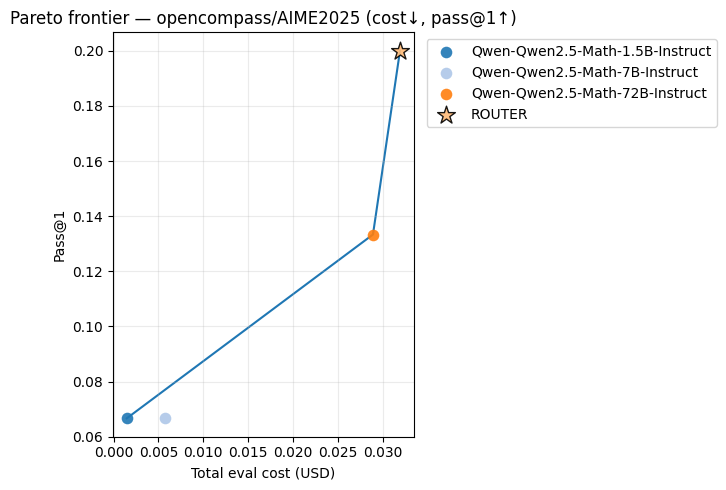



🚏🚦 Routing on gneubig_aime-1983-2024 🚏🚦
Routed: n=933 pass@1=0.3162 cost=1.054054

Qwen-Qwen2.5-Math-1.5B-Instruct     split=train pass@1=0.2776 cost=0.108599
Qwen-Qwen2.5-Math-7B-Instruct       split=train pass@1=0.2797 cost=0.347742
Qwen-Qwen2.5-Math-72B-Instruct      split=train pass@1=0.3580 cost=1.803415


response_model
Qwen/Qwen2.5-Math-7B-Instruct      473
Qwen/Qwen2.5-Math-72B-Instruct     429
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Name: count, dtype: int64

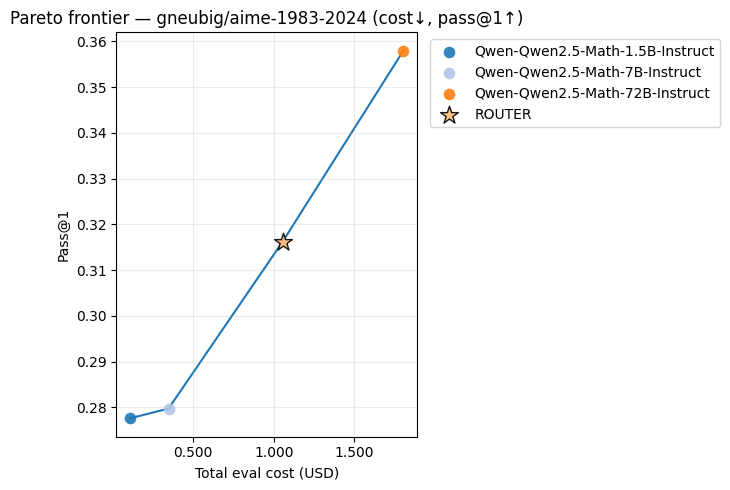



🚏🚦 Routing on openai_gsm8k 🚏🚦
Routed: n=1319 pass@1=0.8863 cost=0.079855

Qwen-Qwen2.5-Math-1.5B-Instruct     split=test  pass@1=0.8279 cost=0.056075
Qwen-Qwen2.5-Math-7B-Instruct       split=test  pass@1=0.9401 cost=0.141240
Qwen-Qwen2.5-Math-72B-Instruct      split=test  pass@1=0.9424 cost=0.810468


response_model
Qwen/Qwen2.5-Math-1.5B-Instruct    1012
Qwen/Qwen2.5-Math-7B-Instruct       305
Qwen/Qwen2.5-Math-72B-Instruct        2
Name: count, dtype: int64

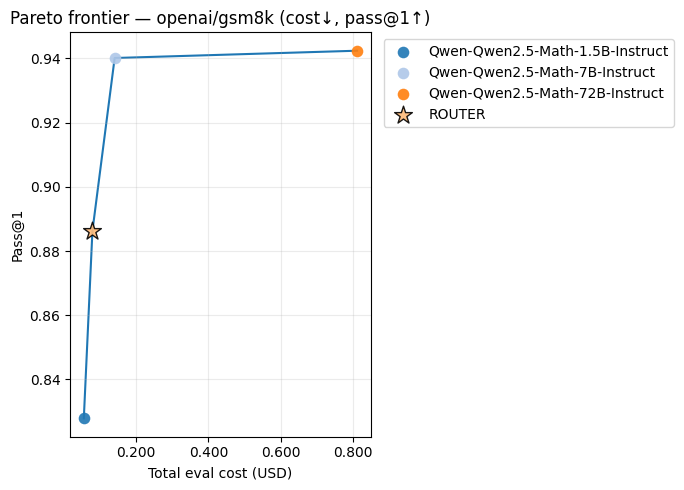



🚏🚦 Routing on DigitalLearningGmbH_MATH-lighteval 🚏🚦
Routed: n=5000 pass@1=0.8012 cost=1.390105

Qwen-Qwen2.5-Math-1.5B-Instruct     split=test  pass@1=0.7226 cost=0.342925
Qwen-Qwen2.5-Math-7B-Instruct       split=test  pass@1=0.8060 cost=0.989091
Qwen-Qwen2.5-Math-72B-Instruct      split=test  pass@1=0.8302 cost=5.363156


response_model
Qwen/Qwen2.5-Math-1.5B-Instruct    2506
Qwen/Qwen2.5-Math-7B-Instruct      2041
Qwen/Qwen2.5-Math-72B-Instruct      453
Name: count, dtype: int64

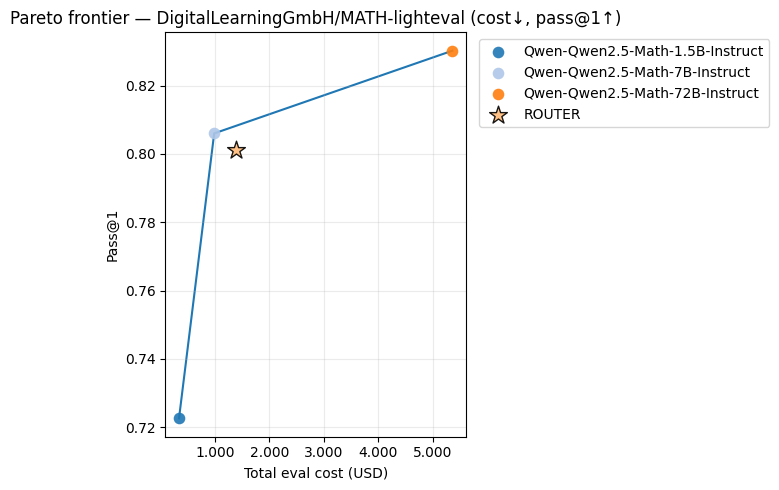

In [109]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ---------------------------
# Pareto + plotting helpers
# ---------------------------
def pareto_efficient_min_cost_max_score(costs, scores, eps=1e-12):
    costs = np.asarray(costs, dtype=float)
    scores = np.asarray(scores, dtype=float)
    n = len(costs)
    is_eff = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_eff[i]:
            continue
        dominated = (costs <= costs[i] + eps) & (scores >= scores[i] - eps) & (
            (costs < costs[i] - eps) | (scores > scores[i] + eps)
        )
        if np.any(dominated):
            is_eff[i] = False
    return is_eff


def plot_pareto_frontier(points, title, x_label="Total eval cost (USD)", y_label="Pass@1"):
    """
    points: list of dicts with keys:
      - name: str  (legend entry; e.g. model alias or "ROUTER")
      - cost: float
      - score: float
      - kind: str  ("model" or "router")
    """
    names = [p["name"] for p in points]
    costs = np.array([p["cost"] for p in points], dtype=float)
    scores = np.array([p["score"] for p in points], dtype=float)

    mask = pareto_efficient_min_cost_max_score(costs, scores)
    pareto_pts = sorted([p for p, m in zip(points, mask) if m], key=lambda d: d["cost"])

    uniq_names = list(dict.fromkeys(names))  # stable order
    cmap = plt.get_cmap("tab20")
    color_map = {n: cmap(i % cmap.N) for i, n in enumerate(uniq_names)}

    fig, ax = plt.subplots(figsize=(9, 5))

    for n in uniq_names:
        pts_n = [p for p in points if p["name"] == n]
        kind = pts_n[0].get("kind", "model")
        marker = "*" if kind == "router" else "o"
        size = 180 if kind == "router" else 70
        edge = "black" if kind == "router" else None

        ax.scatter(
            [p["cost"] for p in pts_n],
            [p["score"] for p in pts_n],
            label=n,
            marker=marker,
            s=size,
            c=[color_map[n]],
            edgecolors=edge,
            linewidths=1.0 if kind == "router" else 0.0,
            alpha=0.9,
            zorder=3 if kind == "router" else 2,
        )

    # Pareto frontier line
    if len(pareto_pts) >= 2:
        ax.plot([p["cost"] for p in pareto_pts], [p["score"] for p in pareto_pts], linewidth=1.5, zorder=1)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True, alpha=0.25)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}"))

    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=True)
    fig.tight_layout(rect=(0, 0, 0.78, 1))
    plt.show()


def pick_og_path_by_rowcount(ds_alias: str, model_alias: str, routed_n: int,
                            base_dir="../../will_replication/DATA/SR_DATA"):
    """
    Because OG parquets don't have `idx`, we choose the split (train/test)
    whose rowcount matches the routed dataframe.
    """
    candidates = []

    if "aime2025" in ds_alias.lower():
        candidates.append(("test", f"{base_dir}/{ds_alias}/test-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
    elif "aime" in ds_alias.lower():
        candidates.append(("train", f"{base_dir}/{ds_alias}/train-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
        candidates.append(("test",  f"{base_dir}/{ds_alias}/test-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
    elif "math" in ds_alias.lower():
        candidates.append(("test",  f"{base_dir}/MATH/test-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
        candidates.append(("train", f"{base_dir}/MATH/train-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
    else:
        candidates.append(("test",  f"{base_dir}/{ds_alias}/test-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))
        candidates.append(("train", f"{base_dir}/{ds_alias}/train-{model_alias}_maxlen_3000_k_1_temp_0.0.parquet"))

    existing = [(split, p) for split, p in candidates if os.path.exists(p)]
    if not existing:
        raise FileNotFoundError(f"No OG parquet found for ds_alias={ds_alias}, model_alias={model_alias}.\nTried:\n" +
                                "\n".join([p for _, p in candidates]))

    # Prefer exact match
    for split, path in existing:
        df = pd.read_parquet(path, columns=["success_rate", "total_cost_usd"])
        if len(df) == routed_n:
            return split, path

    # Fall back to first, but warn upstream via print
    return existing[0][0], existing[0][1]


# ---------------------------
# Reworked main loop:
# - compute routed correctness + cost
# - compute OG points (cost=sum, score=mean) using best split match
# - immediately plot pareto frontier
# ---------------------------
ROUTED_DATASETS_LIST = ["opencompass/AIME2025", "gneubig/aime-1983-2024", "openai/gsm8k", "DigitalLearningGmbH/MATH-lighteval"]
# ROUTED_DATASETS_LIST = ["opencompass/AIME2025"]

for ROUTED_DATASET_NAME in ROUTED_DATASETS_LIST:
    ROUTED_DS_ALIAS = "_".join(ROUTED_DATASET_NAME.split("/"))
    routed_path = f"{ROUTED_DS_ALIAS}_routed_by_{PROBING_DATASET}_{PROBE_MODEL_ALIAS}_final.parquet"
    ROUTED_DF = pd.read_parquet(routed_path)

    # ---- compute routed_is_correct ----
    ROUTED_DF["routed_extracted_ans"] = ROUTED_DF["routed_response_text"].apply(lambda x: try_extract_solution(x))

    if "gsm8k" in ROUTED_DATASET_NAME.lower():
        ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"].apply(extract_gsm8k_solution)
    elif "aime" in ROUTED_DATASET_NAME.lower():
        ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"]
    else:
        ROUTED_DF["extracted_gts"] = ROUTED_DF["original_solution"].apply(extract_solution)

    resp_list = ROUTED_DF["routed_response_text"].tolist()
    gt_list = ROUTED_DF["extracted_gts"].tolist()
    routed_is_correct = []
    for i, res in enumerate(resp_list):
        routed_is_correct.append(compute_score(solution_str=res, ground_truth=gt_list[i]))
    ROUTED_DF["routed_is_correct"] = routed_is_correct

    # ---- router point ----
    routed_score = float(ROUTED_DF["routed_is_correct"].mean())
    routed_cost  = float(ROUTED_DF["total_cost_usd"].sum())
    routed_n = len(ROUTED_DF)

    # ---- OG model points ----
    points = []
    print("\n=============================================================================================")
    print(f"🚏🚦 Routing on {ROUTED_DS_ALIAS} 🚏🚦")
    print(f"Routed: n={routed_n} pass@1={routed_score:.4f} cost={routed_cost:.6f}\n")

    for OG_MODEL_NAME in MODEL_POOL:
        OG_MODEL_ALIAS = "-".join(OG_MODEL_NAME.split("/"))

        split, OG_BENCHMARK_PATH = pick_og_path_by_rowcount(ROUTED_DS_ALIAS, OG_MODEL_ALIAS, routed_n)
        og_benchmark_df = pd.read_parquet(OG_BENCHMARK_PATH)

        benchmark_score = float(og_benchmark_df["success_rate"].mean())
        benchmark_cost  = float(og_benchmark_df["total_cost_usd"].sum())

        if len(og_benchmark_df) != routed_n:
            print(f"⚠️  {OG_MODEL_ALIAS}: split={split} has n={len(og_benchmark_df)} (routed_n={routed_n}). "
                  f"Pareto may be apples-to-oranges.")

        print(f"{OG_MODEL_ALIAS:35s} split={split:5s} pass@1={benchmark_score:.4f} cost={benchmark_cost:.6f}")

        points.append({"name": OG_MODEL_ALIAS, "cost": benchmark_cost, "score": benchmark_score, "kind": "model"})

    # add router
    points.append({"name": "ROUTER", "cost": routed_cost, "score": routed_score, "kind": "router"})

    # (optional) show router dispatch histogram like you had
    display(ROUTED_DF["response_model"].value_counts())

    # ---- plot immediately ----
    plot_pareto_frontier(
        points,
        title=f"Pareto frontier — {ROUTED_DATASET_NAME} (cost↓, pass@1↑)",
        x_label="Total eval cost (USD)",
        y_label="Pass@1",
    )

    print("=============================================================================================\n")


In [106]:
ROUTED_DF['input_num_tokens'].sum() + ROUTED_DF['response_num_tokens'].sum()

21303.0

In [102]:
ROUTED_DF["response_num_tokens"].sum()

19035.0

In [103]:
og_benchmark_df["total_input_tokens"].sum() + og_benchmark_df["total_output_tokens"].sum()

18319

## sanity check pika v2 router

In [34]:
PIKA_V2_DIR = "../pika_router_runs/DigitalLearningGmbH_MATH-lighteval_routed_by_DigitalLearningGmbH_MATH-lighteval_Qwen_Qwen2.5-Math-1.5B-Instruct_probeK5_probeT0.6_routeK5_routeT0.6_sc_final.parquet"

In [72]:
pika_df = pd.read_parquet(PIKA_V2_DIR)

In [36]:
pika_df.columns

Index(['idx', 'problem_id', 'dataset', 'problem', 'formatted_prompt',
       'score_raw', 'score', 'layer', 'pos', 'original_solution', 'level',
       'type', 'calibrated_raw_score', 'calibrated_score', 'route_to',
       'sc_temp', 'sc_n', 'prompt_text', 'routed_response_text',
       'response_model', 'input_num_tokens', 'response_num_tokens',
       'response_latency_s', 'response_error', 'input_cost_usd_once',
       'output_cost_usd', 'total_cost_usd', 'generated_solutions',
       'majority_vote_extracted_answer', 'extracted_gts',
       'majority_vote_is_correct'],
      dtype='object')

In [37]:
pika_df

,idx,problem_id,dataset,problem,formatted_prompt,score_raw,score,layer,pos,original_solution,...,response_num_tokens,response_latency_s,response_error,input_cost_usd_once,output_cost_usd,total_cost_usd,generated_solutions,majority_vote_extracted_answer,extracted_gts,majority_vote_is_correct
0,0,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,DigitalLearningGmbH/MATH-lighteval,How many vertical asymptotes does the graph of...,<|im_start|>system\nPlease reason step by step...,1.003226,0.731692,18,-1,The denominator of the rational function facto...,...,1096.0,16.364981,None,0.000007,0.000110,0.000116,"[{""text"": ""To determine the number of vertical...",2,2,1.0
1,1,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,DigitalLearningGmbH/MATH-lighteval,What is the positive difference between $120\%...,<|im_start|>system\nPlease reason step by step...,1.075277,0.745599,18,-1,One hundred twenty percent of 30 is $120\cdot3...,...,864.0,16.364981,None,0.000007,0.000086,0.000094,"[{""text"": ""To find the positive difference bet...",10,10,1.0
2,2,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,DigitalLearningGmbH/MATH-lighteval,Find $x$ such that $\lceil x \rceil + x = \dfr...,<|im_start|>system\nPlease reason step by step...,0.851081,0.700794,18,-1,"First, we note that $x$ must be positive, sinc...",...,2116.0,16.364981,None,0.000008,0.000212,0.000219,"[{""text"": ""To solve the equation \\(\\lceil x ...",\frac{9}{7},\dfrac{9}{7},1.0
3,3,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQuIExldC...,DigitalLearningGmbH/MATH-lighteval,Evaluate $i^5+i^{-25}+i^{45}$. Let's think ste...,<|im_start|>system\nPlease reason step by step...,1.073896,0.745337,18,-1,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...,...,1294.0,16.364981,None,0.000006,0.000129,0.000135,"[{""text"": ""To evaluate \\(i^5 + i^{-25} + i^{4...",i,i,1.0
4,4,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,DigitalLearningGmbH/MATH-lighteval,"If $2^8=4^x$, what is the value of $x$? Let's ...",<|im_start|>system\nPlease reason step by step...,1.021199,0.735206,18,-1,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...,...,575.0,16.364981,None,0.000006,0.000058,0.000064,"[{""text"": ""To solve the equation \\(2^8 = 4^x\...",4,4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,DigitalLearningGmbH/MATH-lighteval,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,<|im_start|>system\nPlease reason step by step...,0.787648,0.687326,18,-1,"From the given equation, $\cos x = \frac{1}{5}...",...,2622.0,7.713917,None,0.000007,0.000262,0.000270,"[{""text"": ""Given the equation \\(\\sin x + \\c...",-\frac{4}{3},-\frac{4}{3},1.0
4996,4996,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,DigitalLearningGmbH/MATH-lighteval,The matrix for projecting onto a certain plane...,<|im_start|>system\nPlease reason step by step...,0.670913,0.661708,18,-1,Since $\begin{pmatrix} a \\ b \\ c \end{pmatri...,...,5596.0,35.708213,None,0.000036,0.001606,0.001642,"[{""text"": ""To find the normal vector of the pl...",\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},1.0
4997,4997,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,DigitalLearningGmbH/MATH-lighteval,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",<|im_start|>system\nPlease reason step by step...,0.931020,0.717282,18,-1,Since $\mathbf{a} + \mathbf{b} + \mathbf{c} = ...,...,2688.0,7.713917,None,0.000018,0.000269,0.000287,"[{""text"": ""Given the vectors \\(\\mathbf{a}\\)...",-\frac{155}{2},-\frac{155}{2},1.0
4998,4998,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,DigitalLearningGmbH/MATH-lighteval,Find the smallest positive integer solution to...,<|im_start|>system\nPlease reason step by step...,0.674491,0.662508,18,-1,"By the tangent addition formula,\n\begin{align...",...,8238.0,35.708213,None,0.000015,0.002364,0.002379,"[{""text"": ""To solve the equation \\(\\tan{19x^...",159,159,1.0


In [6]:
import json
i = pika_df.index[0]
samples = json.loads(pika_df.loc[i, "generated_solutions"])
len(samples), samples[:2]

(3,
 [{'text': "To determine the expected value of the amount of money Beth will win after rolling a fair six-sided die once, we need to consider the possible outcomes and their probabilities.\n\nFirst, let's identify the possible outcomes when rolling a six-sided die:\n- The numbers on a six-sided die are 1, 2, 3, 4, 5, and 6.\n\nNext, we classify these numbers into prime, composite, and neither categories:\n- Prime numbers: 2, 3, 5\n- Composite numbers: 4, 6\n- Neither: 1\n\nNow, we assign the outcomes and their corresponding monetary values:\n- Rolling a prime number (2, 3, 5): +1 dollar\n- Rolling a composite number (4, 6): -1 dollar\n- Rolling a 1: +0 dollars ( nothing happens)\n\nThe probabilities for each outcome are:\n- Probability of rolling a prime number: \\(\\frac{3}{6} = \\frac{1}{2}\\)\n- Probability of rolling a composite number: \\(\\frac{2}{6} = \\frac{1}{3}\\)\n- Probability of rolling a 1: \\(\\frac{1}{6}\\)\n\nWe can now calculate the expected value \\(E\\) by summi

In [20]:
def get_json_responses(json_sols):
    json_sols = json.loads(json_sols)
    sols_list = []
    for sol in json_sols:
        
        sols_list.append(sol["text"])
    return sols_list

In [ ]:
get_json_responses(pika_df.loc[1501, "generated_solutions"])

["To determine the expected value of the amount of money Beth will win after rolling a fair six-sided die once, we need to consider the possible outcomes and their probabilities.\n\nFirst, let's identify the possible outcomes when rolling a six-sided die:\n- The numbers on a six-sided die are 1, 2, 3, 4, 5, and 6.\n\nNext, we classify these numbers into prime, composite, and neither categories:\n- Prime numbers: 2, 3, 5\n- Composite numbers: 4, 6\n- Neither: 1\n\nNow, we assign the outcomes and their corresponding monetary values:\n- Rolling a prime number (2, 3, 5): +1 dollar\n- Rolling a composite number (4, 6): -1 dollar\n- Rolling a 1: +0 dollars ( nothing happens)\n\nThe probabilities for each outcome are:\n- Probability of rolling a prime number: \\(\\frac{3}{6} = \\frac{1}{2}\\)\n- Probability of rolling a composite number: \\(\\frac{2}{6} = \\frac{1}{3}\\)\n- Probability of rolling a 1: \\(\\frac{1}{6}\\)\n\nWe can now calculate the expected value \\(E\\) by summing the product

In [33]:
extracted_answers = [extract_solution(sol) for sol in get_json_responses(pika_df.loc[1501, "generated_solutions"])]
print(extracted_answers)
total_passk = 0
for ans in extracted_answers:
    total_passk += compute_score(solution_str=f"\\boxed{{{ans}}}", ground_truth="1/6")
print(total_passk)

['\\frac{1}{6}', '\\frac{1}{6}', '\\frac{1}{6}']
3.0


In [70]:
def extract_answers_from_json_solutions(gen_sols_obj):
    return [try_extract_solution(sol) for sol in get_json_responses(gen_sols_obj)]

def compute_passk_from_extracted_answers(extracted_answer_list, ground_truth):
    total_passk = 0
    for extracted_ans in extracted_answer_list:
        total_passk += compute_score(solution_str=f"\\boxed{{{extracted_ans}}}", ground_truth=ground_truth)
    return float(total_passk/len(extracted_answer_list))

def compute_passk_from_json_solutions(generated_sols_obj, ground_truth):
    extracted_answer_list = extract_answers_from_json_solutions(generated_sols_obj)
    return compute_passk_from_extracted_answers(extracted_answer_list, ground_truth)

In [71]:
extract_answers_from_json_solutions(pika_df.loc[200, "generated_solutions"])

['-120', '-209', '-120', '-120', '-120']

In [63]:
pika_df

,idx,problem_id,dataset,problem,formatted_prompt,score_raw,score,layer,pos,original_solution,...,response_latency_s,response_error,input_cost_usd_once,output_cost_usd,total_cost_usd,generated_solutions,majority_vote_extracted_answer,extracted_gts,majority_vote_is_correct,passk
0,0,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,DigitalLearningGmbH/MATH-lighteval,How many vertical asymptotes does the graph of...,<|im_start|>system\nPlease reason step by step...,1.003226,0.731692,18,-1,The denominator of the rational function facto...,...,16.364981,None,0.000007,0.000110,0.000116,"[{""text"": ""To determine the number of vertical...",2,2,1.0,1.000000
1,1,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,DigitalLearningGmbH/MATH-lighteval,What is the positive difference between $120\%...,<|im_start|>system\nPlease reason step by step...,1.075277,0.745599,18,-1,One hundred twenty percent of 30 is $120\cdot3...,...,16.364981,None,0.000007,0.000086,0.000094,"[{""text"": ""To find the positive difference bet...",10,10,1.0,1.000000
2,2,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,DigitalLearningGmbH/MATH-lighteval,Find $x$ such that $\lceil x \rceil + x = \dfr...,<|im_start|>system\nPlease reason step by step...,0.851081,0.700794,18,-1,"First, we note that $x$ must be positive, sinc...",...,16.364981,None,0.000008,0.000212,0.000219,"[{""text"": ""To solve the equation \\(\\lceil x ...",\frac{9}{7},\dfrac{9}{7},1.0,0.666667
3,3,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQuIExldC...,DigitalLearningGmbH/MATH-lighteval,Evaluate $i^5+i^{-25}+i^{45}$. Let's think ste...,<|im_start|>system\nPlease reason step by step...,1.073896,0.745337,18,-1,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...,...,16.364981,None,0.000006,0.000129,0.000135,"[{""text"": ""To evaluate \\(i^5 + i^{-25} + i^{4...",i,i,1.0,1.000000
4,4,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,DigitalLearningGmbH/MATH-lighteval,"If $2^8=4^x$, what is the value of $x$? Let's ...",<|im_start|>system\nPlease reason step by step...,1.021199,0.735206,18,-1,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...,...,16.364981,None,0.000006,0.000058,0.000064,"[{""text"": ""To solve the equation \\(2^8 = 4^x\...",4,4,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,DigitalLearningGmbH/MATH-lighteval,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,<|im_start|>system\nPlease reason step by step...,0.787648,0.687326,18,-1,"From the given equation, $\cos x = \frac{1}{5}...",...,7.713917,None,0.000007,0.000262,0.000270,"[{""text"": ""Given the equation \\(\\sin x + \\c...",-\frac{4}{3},-\frac{4}{3},1.0,1.000000
4996,4996,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,DigitalLearningGmbH/MATH-lighteval,The matrix for projecting onto a certain plane...,<|im_start|>system\nPlease reason step by step...,0.670913,0.661708,18,-1,Since $\begin{pmatrix} a \\ b \\ c \end{pmatri...,...,35.708213,None,0.000036,0.001606,0.001642,"[{""text"": ""To find the normal vector of the pl...",\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},1.0,0.600000
4997,4997,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,DigitalLearningGmbH/MATH-lighteval,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",<|im_start|>system\nPlease reason step by step...,0.931020,0.717282,18,-1,Since $\mathbf{a} + \mathbf{b} + \mathbf{c} = ...,...,7.713917,None,0.000018,0.000269,0.000287,"[{""text"": ""Given the vectors \\(\\mathbf{a}\\)...",-\frac{155}{2},-\frac{155}{2},1.0,1.000000
4998,4998,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,DigitalLearningGmbH/MATH-lighteval,Find the smallest positive integer solution to...,<|im_start|>system\nPlease reason step by step...,0.674491,0.662508,18,-1,"By the tangent addition formula,\n\begin{align...",...,35.708213,None,0.000015,0.002364,0.002379,"[{""text"": ""To solve the equation \\(\\tan{19x^...",159,159,1.0,0.400000


In [ ]:
pika_df["passk"] = pika_df.apply(
    lambda row: compute_passk_from_json_solutions(generated_sols_obj=row["generated_solutions"], ground_truth=row["extracted_gts"]),
    axis=1
)

In [65]:
pika_df

,idx,problem_id,dataset,problem,formatted_prompt,score_raw,score,layer,pos,original_solution,...,response_latency_s,response_error,input_cost_usd_once,output_cost_usd,total_cost_usd,generated_solutions,majority_vote_extracted_answer,extracted_gts,majority_vote_is_correct,passk
0,0,SG93IG1hbnkgdmVydGljYWwgYXN5bXB0b3RlcyBkb2VzIH...,DigitalLearningGmbH/MATH-lighteval,How many vertical asymptotes does the graph of...,<|im_start|>system\nPlease reason step by step...,1.003226,0.731692,18,-1,The denominator of the rational function facto...,...,16.364981,None,0.000007,0.000110,0.000116,"[{""text"": ""To determine the number of vertical...",2,2,1.0,1.000000
1,1,V2hhdCBpcyB0aGUgcG9zaXRpdmUgZGlmZmVyZW5jZSBiZX...,DigitalLearningGmbH/MATH-lighteval,What is the positive difference between $120\%...,<|im_start|>system\nPlease reason step by step...,1.075277,0.745599,18,-1,One hundred twenty percent of 30 is $120\cdot3...,...,16.364981,None,0.000007,0.000086,0.000094,"[{""text"": ""To find the positive difference bet...",10,10,1.0,1.000000
2,2,RmluZCAkeCQgc3VjaCB0aGF0ICRcbGNlaWwgeCBccmNlaW...,DigitalLearningGmbH/MATH-lighteval,Find $x$ such that $\lceil x \rceil + x = \dfr...,<|im_start|>system\nPlease reason step by step...,0.851081,0.700794,18,-1,"First, we note that $x$ must be positive, sinc...",...,16.364981,None,0.000008,0.000212,0.000219,"[{""text"": ""To solve the equation \\(\\lceil x ...",\frac{9}{7},\dfrac{9}{7},1.0,0.666667
3,3,RXZhbHVhdGUgJGleNStpXnstMjV9K2leezQ1fSQuIExldC...,DigitalLearningGmbH/MATH-lighteval,Evaluate $i^5+i^{-25}+i^{45}$. Let's think ste...,<|im_start|>system\nPlease reason step by step...,1.073896,0.745337,18,-1,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...,...,16.364981,None,0.000006,0.000129,0.000135,"[{""text"": ""To evaluate \\(i^5 + i^{-25} + i^{4...",i,i,1.0,1.000000
4,4,SWYgJDJeOD00XngkLCB3aGF0IGlzIHRoZSB2YWx1ZSBvZi...,DigitalLearningGmbH/MATH-lighteval,"If $2^8=4^x$, what is the value of $x$? Let's ...",<|im_start|>system\nPlease reason step by step...,1.021199,0.735206,18,-1,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...,...,16.364981,None,0.000006,0.000058,0.000064,"[{""text"": ""To solve the equation \\(2^8 = 4^x\...",4,4,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,SWYgJFxzaW4geCArIFxjb3MgeCA9IFxmcmFjezF9ezV9JC...,DigitalLearningGmbH/MATH-lighteval,If $\sin x + \cos x = \frac{1}{5}$ and $0 < x ...,<|im_start|>system\nPlease reason step by step...,0.787648,0.687326,18,-1,"From the given equation, $\cos x = \frac{1}{5}...",...,7.713917,None,0.000007,0.000262,0.000270,"[{""text"": ""Given the equation \\(\\sin x + \\c...",-\frac{4}{3},-\frac{4}{3},1.0,1.000000
4996,4996,VGhlIG1hdHJpeCBmb3IgcHJvamVjdGluZyBvbnRvIGEgY2...,DigitalLearningGmbH/MATH-lighteval,The matrix for projecting onto a certain plane...,<|im_start|>system\nPlease reason step by step...,0.670913,0.661708,18,-1,Since $\begin{pmatrix} a \\ b \\ c \end{pmatri...,...,35.708213,None,0.000036,0.001606,0.001642,"[{""text"": ""To find the normal vector of the pl...",\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},\begin{pmatrix} 1 \\ 2 \\ -3 \end{pmatrix},1.0,0.600000
4997,4997,TGV0ICRcbWF0aGJme2F9LCQgJFxtYXRoYmZ7Yn0sJCBhbm...,DigitalLearningGmbH/MATH-lighteval,"Let $\mathbf{a},$ $\mathbf{b},$ and $\mathbf{c...",<|im_start|>system\nPlease reason step by step...,0.931020,0.717282,18,-1,Since $\mathbf{a} + \mathbf{b} + \mathbf{c} = ...,...,7.713917,None,0.000018,0.000269,0.000287,"[{""text"": ""Given the vectors \\(\\mathbf{a}\\)...",-\frac{155}{2},-\frac{155}{2},1.0,1.000000
4998,4998,RmluZCB0aGUgc21hbGxlc3QgcG9zaXRpdmUgaW50ZWdlci...,DigitalLearningGmbH/MATH-lighteval,Find the smallest positive integer solution to...,<|im_start|>system\nPlease reason step by step...,0.674491,0.662508,18,-1,"By the tangent addition formula,\n\begin{align...",...,35.708213,None,0.000015,0.002364,0.002379,"[{""text"": ""To solve the equation \\(\\tan{19x^...",159,159,1.0,0.400000


In [67]:
pika_df["majority_vote_is_correct"].mean()

0.7994

In [66]:
pika_df["passk"].mean()

0.7711333333333334

In [68]:
pika_df["total_cost_usd"].sum()

3.000318119